Multi Linear Band Gap Models based on Perovskite Compositions
=============================================================

**Author:** Panayotis Manganaris



In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys, os
sys.path.append(os.path.expanduser("~/src/cmcl"))
sys.path.append(os.path.expanduser("~/src/yogi"))
sys.path.append(os.path.expanduser("~/src/spyglass"))

In [1]:
# featurization
import cmcl
from cmcl import Categories
# multi-criterion model evaluation
from yogi.model_selection import summarize_HPO
from yogi.model_selection import pandas_validation_curve as pvc
from yogi.metrics.pandas_scoring import PandasScoreAdaptor as PSA
from yogi.metrics.pandas_scoring import batch_score
# visualization convenience
from spyglass.model_imaging import parityplot

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

In [1]:
# data tools
import sqlite3
import pandas as pd
import numpy as np
# feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler
# predictors
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
## pipeline workflow
from sklearn.pipeline import make_pipeline as mkpipe
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV as gsCV
# model eval
from sklearn.base import clone
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, explained_variance_score, max_error
import joblib
#visualization
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background")
# ignore all FutureWarnings -- handling coming in a future version of yogi
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## dependencies



"cmcl" and "yogi" are our in-house modules for analyzing chemical
compositions and enabling different nuts and bolts of ML algorithms.



In [1]:
# featurization
import cmcl
from cmcl import Categories
# multi-criterion model evaluation
from yogi.model_selection import summarize_HPO
from yogi.model_selection import pandas_validation_curve as pvc
from yogi.metrics.pandas_scoring import PandasScoreAdaptor as PSA
from yogi.metrics.pandas_scoring import batch_score
# visualization convenience
from spyglass.model_imaging import parityplot

The Intel distribution provides accelerated ml algorithms. Run this
cell before importing the algorithms.



In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

In [1]:
# data tools
import sqlite3
import pandas as pd
import numpy as np
# feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler
# predictors
from sklearn.linear_model import LinearRegression, ElasticNet
## pipeline workflow
from sklearn.pipeline import make_pipeline as mkpipe
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV as gsCV
# model eval
from sklearn.base import clone
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, explained_variance_score, max_error
import joblib
#visualization
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
# ignore all FutureWarnings -- handling coming in a future version of yogi
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Load Data Using Cmcl and Compute Composition Vectors



In [1]:
sqlmannodi = """SELECT *
            FROM mannodi_base"""
sqlref = """SELECT *
            FROM mannodi_ref_elprop"""
sqlalmora = """SELECT *
               FROM almora_agg"""
with sqlite3.connect("/home/panos/src/cmcl/cmcl/db/perovskites.db") as conn:
    mannodi = pd.read_sql(sqlmannodi, conn, index_col="index")
    lookup = pd.read_sql(sqlref, conn, index_col='index')
    almora = pd.read_sql(sqlalmora, conn, index_col='index')

## Clean Data and Compute Composition Vectors



In [1]:
lookup = lookup.set_index("Formula")
mannodi = mannodi.set_index(["Formula", "sim_cell"], append=True)

### subset base on deviation from cubicity



In [1]:
mannodi = mannodi.drop(index=["Rb0.375Cs0.625GeBr3", "RbGeBr1.125Cl1.875", "K0.75Cs0.25GeI3", "K8Sn8I9Cl15"], level=1)
maincomp = mannodi.ft.comp().iloc[:, :14:]

### auto subset index



In [1]:
size = mannodi.index.isin(["2x2x2"], level="sim_cell")
#maincomp
maincomp = maincomp.collect.abx()
mcg = maincomp.groupby(level=0, axis=1).sum()
mvB, mvX, mvA, = mcg.A.isin([1, 8]), mcg.B.isin([1, 8]), mcg.X.isin([3, 24])
#subset indexes
mfocus = size*mvB*mvA*mvX

### apply subsets



In [1]:
mc = maincomp[mfocus]
my = mannodi[mfocus]

### generate mix category and assign to index for future imaging



In [1]:
mixlog = mc.groupby(level=0, axis=1).count()
mix = mixlog.pipe(Categories.logif, condition=lambda x: x>1, default="pure", catstring="and")
mc = mc.assign(mix=mix).set_index("mix", append=True)
my = my.assign(mix=mix).set_index("mix", append=True)

## Model BG Using Composition Vectors



This model will be based on a simple least squares linear
regression. The data will be normalized as discussed in visualizations.



### Make Composition Pipeline



In [1]:
fillna = SimpleImputer(strategy="constant", fill_value=0.0)
cpipe = mkpipe(fillna, Normalizer('l1'), LinearRegression())

### Scoring Scheme



#### prepare subset scoring weights and ordinal group labels



In [1]:
mixweight = pd.get_dummies(mix)
mixcat = pd.Series(OrdinalEncoder().fit_transform(mix.values.reshape(-1, 1)).reshape(-1),
                     index=mc.index).astype(int)

#### Define Scoring Metrics



In [1]:
site_mse = PSA(mean_squared_error).score
scorings = {'r2': make_scorer(r2_score),
            'ev': make_scorer(explained_variance_score),
            'maxerr': make_scorer(max_error, greater_is_better=False),
            'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
            'A_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.A),
            'B_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.B),
            'X_rmse': make_scorer(site_mse, greater_is_better=False,
                                  squared=False, sample_weight=mixweight.X),
            'BandX_rmse': make_scorer(site_mse, greater_is_better=False,
                                      squared=False, sample_weight=mixweight.BandX),
            'Pure_rmse': make_scorer(site_mse, greater_is_better=False,
                                     squared=False, sample_weight=mixweight.pure),}

### Make Dedicated Test Train Split



In [1]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=None)
train_idx, test_idx = next(sss.split(mc, mixcat)) #stratify split by mix categories
mc_tr, mc_ts = mc.iloc[train_idx], mc.iloc[test_idx]
my_tr, my_ts = my.iloc[train_idx], my.iloc[test_idx]
mixcat_tr, mixcat_ts = mixcat.iloc[train_idx], mixcat.iloc[test_idx]

### Learning Curves &#x2013; Using Deterministically Random Cross Validation



In [1]:
kf_lc = KFold(n_splits=10, shuffle=True, random_state=111)

In [1]:
with joblib.parallel_backend('multiprocessing'):
  LC = pvc(learning_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           train_sizes=np.linspace(0.1, 1.0, 10), cv=kf_lc, scoring=scorings)
  LC = LC.melt(id_vars=["partition"], ignore_index=False).reset_index()

/opt/miniconda3/envs/mrsicms/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.

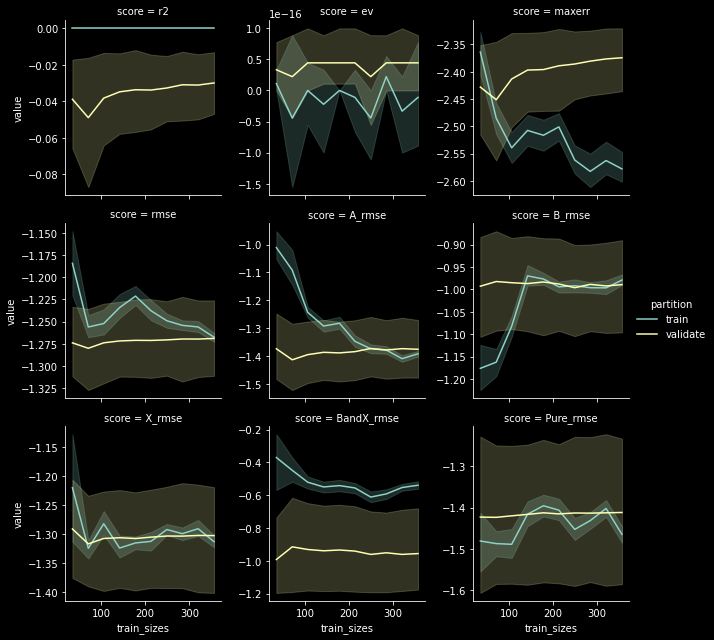

In [1]:
p = sns.FacetGrid(LC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, "train_sizes", "value")
p.add_legend()
p.figure.show()

It appears that 2-3 fold cross-validation is sufficient (training with
200/400 or 260/400 points, validating with the compliment)

The Linear Regressor validation scores tend to cap out after about
200 data points have been seen. Giving this regressor more data likely
won't help.



### Obtain Generality Baseline



In [1]:
gkf = GroupKFold(n_splits=4)

In [1]:
def test_generality(estimator, X_tr, y_tr, groups_tr, X_ts, y_ts, groups_ts):
    estimator = clone(estimator) #unfitted, cloned params
    gentpl = gkf.split(X_tr, y_tr, groups=groups_tr), gkf.split(X_ts, y_ts, groups=groups_ts)
    #train and test index generators, in order
    val_scores = []
    tst_scores = []
    for train_idx, val_idx, _, tst_idx in [sum(gengroup, ()) for gengroup in zip(*gentpl)]:
        tr_val_group_names = groups_tr.iloc[val_idx].index.get_level_values("mix").unique()
        ts_group_names = groups_ts.iloc[tst_idx].index.get_level_values("mix").unique()
        #fit to tr part
        estimator.fit(X_tr.iloc[train_idx], y_tr.iloc[train_idx])
        #get val and test scores
        tr_val_score_series = pd.Series(batch_score(estimator, X_tr.iloc[val_idx], y_tr.iloc[val_idx], **scorings))
        tr_val_score_series.name="_&_".join(tr_val_group_names)
        ts_score_series = pd.Series(batch_score(estimator, X_ts.iloc[tst_idx], y_ts.iloc[tst_idx], **scorings))
        ts_score_series.name="_&_".join(ts_group_names)
        val_scores.append(tr_val_score_series)
        tst_scores.append(ts_score_series)
    tr_val_scores = pd.concat(val_scores, axis=1).assign(partition="validation")
    ts_scores = pd.concat(tst_scores, axis=1).assign(partition="test")
    group_scores = pd.concat([tr_val_scores, ts_scores]).round(5).drop_duplicates(keep="first")
    return group_scores

In [1]:
test_generality(cpipe, mc_tr, my_tr.PBE_bg_eV, mixcat_tr, mc_ts, my_ts.PBE_bg_eV, mixcat_ts)

|            | B        | X        | A        | pure_&_BandX | partition  |
|------------+----------+----------+----------+--------------+------------|
| r2         | 0.85899  | 0.89520  | 0.92892  | 0.96176      | validation |
| ev         | 0.85989  | 0.90245  | 0.94111  | 0.96199      | validation |
| maxerr     | -1.14456 | -1.35640 | -1.42404 | -0.78893     | validation |
| rmse       | -0.36811 | -0.43058 | -0.37989 | -0.29830     | validation |
| BandX_rmse | -0.36811 | -0.43058 | -0.37989 | -0.23984     | validation |
| Pure_rmse  | -0.36811 | -0.43058 | -0.37989 | -0.30121     | validation |
| r2         | 0.82520  | 0.89658  | 0.85516  | 0.91541      | test       |
| ev         | 0.83679  | 0.89664  | 0.87529  | 0.91990      | test       |
| maxerr     | -0.87784 | -1.34002 | -1.35774 | -0.86058     | test       |
| rmse       | -0.39654 | -0.45242 | -0.47998 | -0.33557     | test       |
| BandX_rmse | -0.39654 | -0.45242 | -0.47998 | -0.20772     | test       |
| Pure_rmse 

-   extrapolations are not very accurate, but generally within 0.5 eV
    -   in the test partition, the model utterly fails in extrapolating the bandgaps of B-mixed alloys
    -   in the train partition scores are similar



### Best Model



#### Parametrize



Default parameters used. Linear regression is very simple



#### Train Final Estimator



In [1]:
#cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})
cpipe.fit(mc_tr, my_tr.PBE_bg_eV)

[INFO] 2022-05-05 18:26:41 - sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0.0, strategy='constant')),
                ('normalizer', Normalizer(norm='l1')),
                ('linearregression', LinearRegression())])

#### evaluate



[INFO] 2022-05-05 18:26:43 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
/opt/miniconda3/envs/mrsicms/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
#+attr_org: :width 434

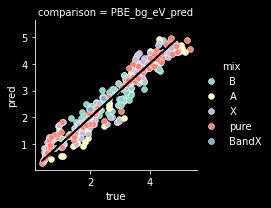

In [1]:
#change between tr and ts suffixes to see test vs train pairity plot
p, data = parityplot(cpipe, mc_tr, my_tr.PBE_bg_eV.to_frame(), aspect=1.0, hue="mix")
p.figure.show()

In [1]:
#optionally save the figure for presentation
p.savefig("../ParityPlots/linear_bg_c.png", transparent=True)

In [1]:
#change between tr and ts suffixes to see test vs train scores -- both are good
pd.Series(batch_score(cpipe, mc_ts, my_ts.PBE_bg_eV, **scorings)).to_frame()

[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:26:55 - sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
|

#### discussion



The linear model is actually pretty reasonable, but it's unlikely that
it's learning anything very fundamental about the underlying physics
of the Pervoskite system. however, that doesn't mean it reveals nothing.



In [1]:
interpret = pd.Series(cpipe[-1].coef_, index=mc_tr.columns)
interpret

#+begin_example
  site  element
  A     Cs         23.771206
        FA         25.794831
        K          22.774475
        MA         25.452629
        Rb         23.282988
  B     Ba        -32.603053
        Ca        -31.378385
        Ge        -45.001044
        Pb        -42.526511
        Sn        -46.868114
        Sr        -32.068490
  X     Br          0.939374
        Cl          1.769032
        I           0.140658
  dtype: float64
#+end_example

In [1]:
interpret.groupby(level=0).aggregate(lambda x: np.sqrt(sum(x**2)))

site
A    54.213044
B    95.426246
X     2.007905
dtype: float64

To illustrate, the coefficients that define the linear combination do
not find much use in X-site elements. however, the B site elements
contribute much more to the band gap on average, which is consistent
with our physical understanding.

Curiously, A site elements also prove to be relevant.

Likewise, with respect to the generality measure conducted earlier, it
seems the presence of individual elements is far more predictive of
the total band gap than mix status. This would explain why X-site and
A-site alloys are sufficient to predict the band gaps of B-site alloys,
despite those groups containing no B-site alloys themselves, they do
contain a representative sample of B-site elements.



## Model BG Using Composition Vectors



The features used here, especially after l1 normalization, are
proportions of a total. By definition they are correlated. So, it is
worth using a more intelligent linear regression to try extracting an
indication of the most impactful features.

ElasticNet uses Lasso in combination with l1 and l2 regularization of
the model parameters to encourage sparsity. however, it is not
especially strict. unlike Lasso (another sparsifying linear
regressor), ElasticNet will use multiple sets of correlated features
instead of &#x2013; effectively randomly &#x2013; picking only one in the effort
to return sparse coefficients.



### Make Composition Pipeline



The higher the alpha value, the more aggressively elasticnet will
minimize it's weights. an alpha value of 1 will force all weights to
zero.



In [1]:
fillna = SimpleImputer(strategy="constant", fill_value=0.0)
cpipe = mkpipe(fillna, Normalizer('l1'), ElasticNet(alpha=0.001, l1_ratio=0.5))

### Make Dedicated Test Train Split



In [1]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=None)
train_idx, test_idx = next(sss.split(mc, mixcat)) #stratify split by mix categories
mc_tr, mc_ts = mc.iloc[train_idx], mc.iloc[test_idx]
my_tr, my_ts = my.iloc[train_idx], my.iloc[test_idx]
mixcat_tr, mixcat_ts = mixcat.iloc[train_idx], mixcat.iloc[test_idx]

### Learning Curves &#x2013; Using Deterministically Random Cross Validation



In [1]:
kf_lc = KFold(n_splits=10, shuffle=True, random_state=111)

In [1]:
with joblib.parallel_backend('multiprocessing'):
  LC = pvc(learning_curve, cpipe, mc_tr, my_tr.PBE_bg_eV,
           train_sizes=np.linspace(0.1, 1.0, 10), cv=kf_lc, scoring=scorings)
  LC = LC.melt(id_vars=["partition"], ignore_index=False).reset_index()

/opt/miniconda3/envs/mrsicms/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.

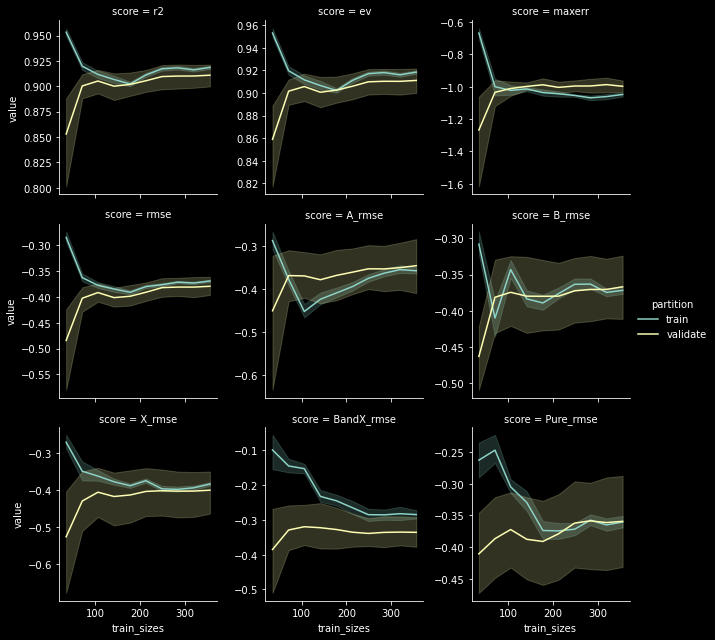

In [1]:
p = sns.FacetGrid(LC, col="score", hue="partition", col_wrap=3, sharey=False)
p.map(sns.lineplot, "train_sizes", "value")
p.add_legend()
p.figure.show()

Like the normal least squares regressor, elastic net quickly saturates to a maximum score.

-   scores are decent
-   the point really is to see if any of the features are effectively redundant contributors.



### Obtain Generality Baseline



In [1]:
gkf = GroupKFold(n_splits=4)

In [1]:
test_generality(cpipe, mc_tr, my_tr.PBE_bg_eV, mixcat_tr, mc_ts, my_ts.PBE_bg_eV, mixcat_ts)

|            | B        | X        | A        | pure_&_BandX | partition  |
|------------+----------+----------+----------+--------------+------------|
| r2         | 0.84832  | 0.91180  | 0.92628  | 0.93378      | validation |
| ev         | 0.84898  | 0.91603  | 0.93741  | 0.93452      | validation |
| maxerr     | -1.04160 | -1.09773 | -1.10444 | -0.97260     | validation |
| rmse       | -0.39282 | -0.40429 | -0.37619 | -0.37490     | validation |
| BandX_rmse | -0.39282 | -0.40429 | -0.37619 | -0.29242     | validation |
| Pure_rmse  | -0.39282 | -0.40429 | -0.37619 | -0.37895     | validation |
| r2         | 0.75869  | 0.87056  | 0.86833  | 0.91686      | test       |
| ev         | 0.81312  | 0.87503  | 0.88454  | 0.92124      | test       |
| maxerr     | -0.84890 | -0.95087 | -1.27632 | -1.01095     | test       |
| rmse       | -0.39500 | -0.46152 | -0.51210 | -0.42939     | test       |
| BandX_rmse | -0.39500 | -0.46152 | -0.51210 | -0.24685     | test       |
| Pure_rmse 

-   extrapolations are not very accurate, but generally within 0.5 eV
    -   in the test partition, the model utterly fails in extrapolating the bandgaps of B-mixed alloys
    -   in the train partition scores are similar



### Best Model



#### Parametrize



Default parameters used. Linear regression is very simple



#### Train Final Estimator



In [1]:
#cpipe = cpipe.set_params(**{k:v[0] for k,v in grid[0].items()})
cpipe.fit(mc_tr, my_tr.PBE_bg_eV)

[INFO] 2022-05-05 18:12:14 - sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0.0, strategy='constant')),
                ('normalizer', Normalizer(norm='l1')),
                ('elasticnet', ElasticNet(alpha=0.001))])

#### evaluate



[INFO] 2022-05-05 18:12:15 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
/opt/miniconda3/envs/mrsicms/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
#+attr_org: :width 434

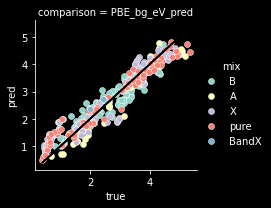

In [1]:
#change between tr and ts suffixes to see test vs train pairity plot
p, data = parityplot(cpipe, mc_tr, my_tr.PBE_bg_eV.to_frame(), aspect=1.0, hue="mix")
p.figure.show()

In [1]:
#optionally save the figure for presentation
p.savefig("../ParityPlots/elastic_bg_c.png", transparent=True)

In [1]:
#change between tr and ts suffixes to see test vs train scores -- both are good
pd.Series(batch_score(cpipe, mc_ts, my_ts.PBE_bg_eV, **scorings)).to_frame()

[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
[INFO] 2022-05-05 18:12:26 - sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
|            | 0         |
|------------+-----------|
|

#### discussion



The linear model is actually pretty reasonable, but it's unlikely that
it's learning anything very fundamental about the underlying physics
of the Pervoskite system. however, that doesn't mean it reveals nothing.



In [1]:
interpret = pd.Series(cpipe[-1].coef_, index=mc_tr.columns)
interpret

#+begin_example
  site  element
  A     Cs        -0.191057
        FA         1.589015
        K         -1.081903
        MA         1.214167
        Rb        -0.530437
  B     Ba         5.139688
        Ca         6.424156
        Ge        -5.879154
        Pb        -3.673012
        Sn        -7.689152
        Sr         5.678253
  X     Br         0.000000
        Cl         0.819669
        I         -0.786942
  dtype: float64
#+end_example

Here we start to see that more complicated models appear to take
A-site elements more seriously.



In [1]:
interpret.groupby(level=0).aggregate(lambda x: np.sqrt(sum(x**2)))

site
A     2.342552
B    14.391222
X     1.136281
dtype: float64

To illustrate, the coefficients that define the linear combination do
not find much use in X-site elements. however, the B site elements
contribute much more to the band gap on average, which is consistent
with our physical understanding.

Curiously, A site elements also prove to be relevant.

Likewise, with respect to the generality measure conducted earlier, it
seems the presence of individual elements is far more predictive of
the total band gap than mix status. This would explain why X-site and
A-site alloys are sufficient to predict the band gaps of B-site alloys,
despite those groups containing no B-site alloys themselves, they do
contain a representative sample of B-site elements.

Finally, this exercise results in one important conclusion:

Despite the fact that the composition space definitely consists of
correlated features, very few of them can be easily called
redundant.

Additionally, comparing the ElasticNet scores to the standard linear
regression shows using all features seems to result in better
performance.

